In [179]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import requests
from datetime import datetime

In [180]:
# functions

# get ohlcv from broker
def ohlcv(symbol, resolution, start, stop):
    base_url = 'https://api.nobitex.ir/market/udf/history'
    
    ohlc_url = f"{base_url}?symbol={symbol}&resolution={resolution}&from={start}&to={stop}"
    
    response = requests.get(ohlc_url)
    data =  response.json()
    
    ohlcv_data = pd.DataFrame({
            'Time': data['t'],
            'Open': data['o'],
            'High': data['h'],
            'Low': data['l'],
            'Close': data['c'],
            'Volume': data['v']
        })
    ohlcv_data['Time'] = pd.to_datetime(ohlcv_data['Time'], unit='s')
    
    return ohlcv_data

# convert datetime to timestamp
def get_datetime_timestamp(date_string):
    # Parse the date string to datetime
    dt = datetime.strptime(date_string, "%Y-%m-%d")
    # Get timestamp
    timestamp = dt.timestamp()
    return  timestamp

def get_historical_data(pairs, time_frame, start_time ,stop_time):
    """ this functions return a dataframe of closing prices"""
    
    data = pd.DataFrame()
    names = list()

    for i in pairs:
        data = pd.concat([data, ohlcv(i, time_frame, start_time, stop_time).iloc[:,4]], axis=1)
        names.append(i)
    data.columns = names
    
    return data
        

In [181]:
ticks = ['btcusdt', 'adausdt', 'solusdt', 'xrpusdt', 'dogeusdt', 'ethusdt', 'xlmusdt']

strat_date = get_datetime_timestamp('2024-4-12')
stop_date = get_datetime_timestamp('2025-4-13')

df = get_historical_data(ticks, 'D', strat_date, stop_date)

print(df)


      btcusdt  adausdt  solusdt  xrpusdt  dogeusdt  ethusdt  xlmusdt
0    67600.00   0.4970  153.336  0.54678  0.172700  3260.00  0.11402
1    61620.00   0.4010  120.109  0.44440  0.137800  2920.00  0.09533
2    64149.00   0.4520  143.000  0.49132  0.151700  3073.16  0.10784
3    63200.00   0.4549  137.896  0.49300  0.159615  3097.22  0.10577
4    62778.97   0.4532  133.665  0.49360  0.154100  3055.20  0.10730
..        ...      ...      ...      ...       ...      ...      ...
361  76411.03   0.5601  104.227  1.81836  0.142999  1474.95  0.22061
362  81594.00   0.6270  118.296  2.02100  0.160099  1643.77  0.24162
363  79443.17   0.6014  111.693  1.96739  0.154371  1519.99  0.22979
364  83379.00   0.6288  121.248  2.04017  0.160404  1570.30  0.23467
365  84597.69   0.6580  131.189  2.14635  0.166537  1637.46  0.24528

[366 rows x 7 columns]


In [182]:
corr_matrix = df.corr()
corr_matrix

,btcusdt,adausdt,solusdt,xrpusdt,dogeusdt,ethusdt,xlmusdt
btcusdt,1.000000,0.937576,0.728091,0.912077,0.902600,0.186869,0.930386
adausdt,0.937576,1.000000,0.700775,0.887714,0.919198,0.280551,0.972430
solusdt,0.728091,0.700775,1.000000,0.481271,0.866085,0.592422,0.672479
xrpusdt,0.912077,0.887714,0.481271,1.000000,0.718564,-0.058635,0.911931
dogeusdt,0.902600,0.919198,0.866085,0.718564,1.000000,0.446059,0.884408
ethusdt,0.186869,0.280551,0.592422,-0.058635,0.446059,1.000000,0.193993
xlmusdt,0.930386,0.972430,0.672479,0.911931,0.884408,0.193993,1.000000


<Axes: >

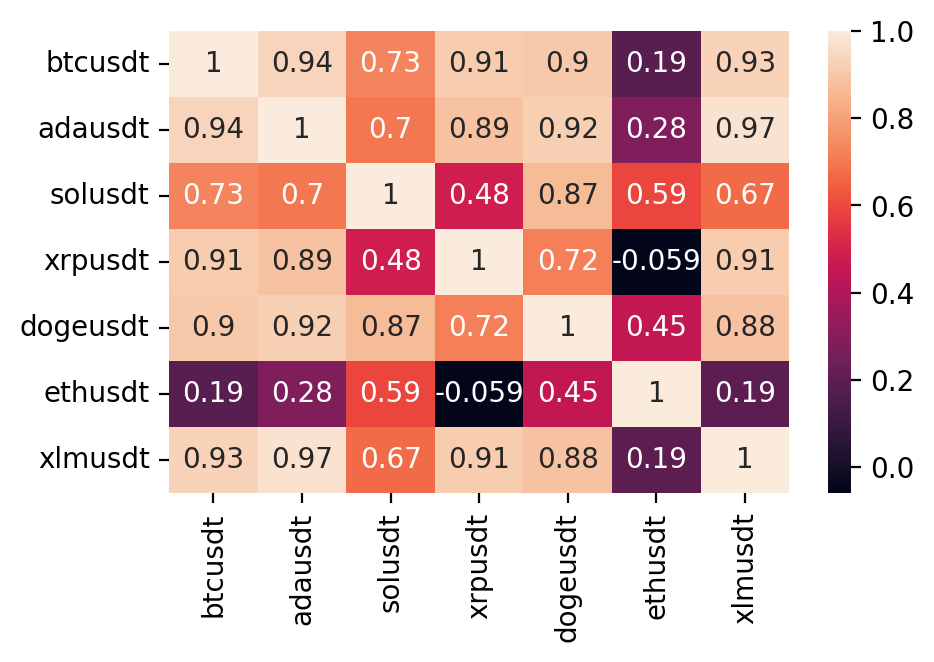

In [183]:
# Let's heatmap this matrix so that we can have a better sense of what is going on
plt.figure(figsize=(5, 3), dpi=200)
sn.heatmap(corr_matrix, annot = True)

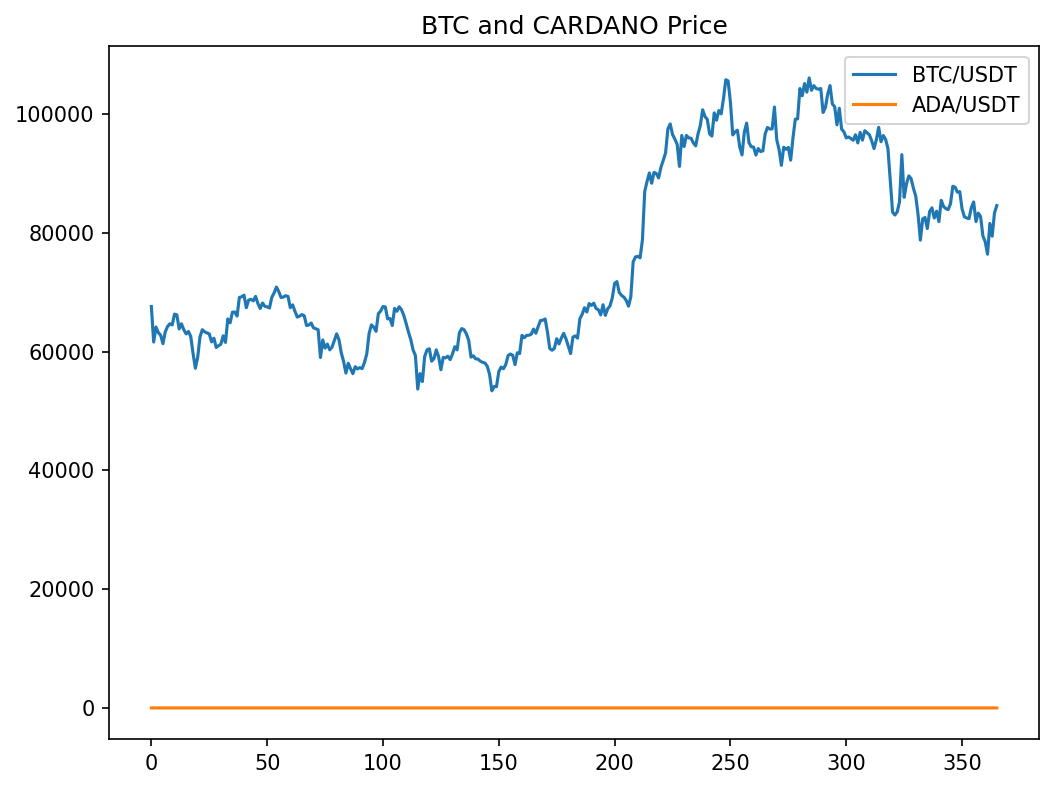

In [189]:
plt.figure(figsize=(8, 6), dpi=150)
BTC = df['btcusdt']
ADA = df['adausdt']

plt.plot(BTC, label='BTC/USDT')
plt.plot(ADA, label='ADA/USDT')
plt.title('BTC and CARDANO Price')
plt.legend()

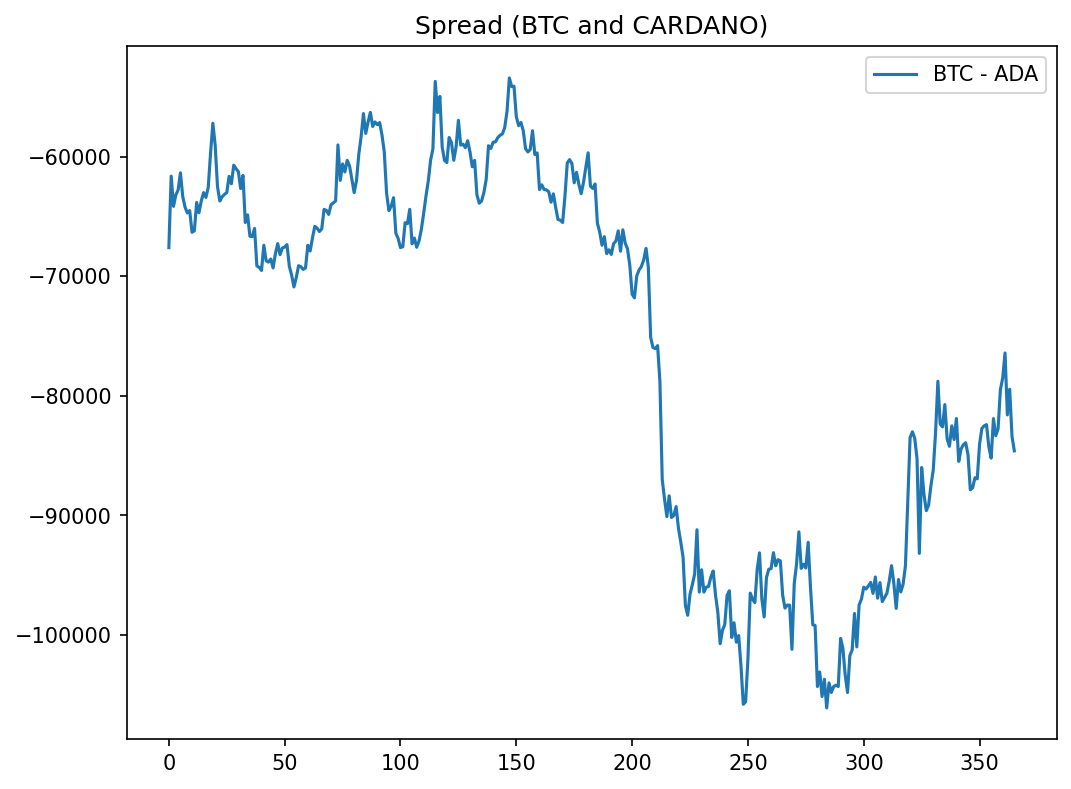

In [190]:
plt.figure(figsize=(8, 6), dpi=150)
plt.plot(ADA - BTC, label='BTC - ADA')
plt.title('Spread (BTC and CARDANO)')
plt.legend()

In [191]:
# check out the cointegration value : Null = no cointegration, 1 = cointegration
import statsmodels.tsa.stattools as ts
result = ts.coint(BTC, ADA)

In [192]:
# cointegration test: a technique used to find a potential correlation in a time series
# Detemines if the spread betwwen the two assets are constant over time.
# Null hypothesis: the two time series are non-stationary.
cointegration_t_statistic = result[0]
p_value = result[1]
critical_values_test_statistic_at_1_5_10 = result[2]
print('We want the P val < 0.05 (meaning that cointegration exists)')
print('P value for the augmented Engle-Granger two-step cointegration test is', p_value)

We want the P val < 0.05 (meaning that cointegration exists)
P value for the augmented Engle-Granger two-step cointegration test is 0.05758549470115969


In [193]:
from statsmodels.tsa.stattools import adfuller
# Compute the ADF tetst for Bitcoin and Cardano
# With all time series, you want to have sationary data otherwise our data will be very hard to predict.
# ADF for Bitcoin
BTC_ADF = adfuller(BTC)
print('P value for the Agumeted Dickey-Fuller Test is:', BTC_ADF[1])
ADA_ADF = adfuller(ADA)
print('P value for the Agumeted Dickey-Fuller Test is:', ADA_ADF[1])
Spread_ADF = adfuller(BTC - ADA)
print('P value for the Augmented Dickey-Fuller Test is', Spread_ADF[1])
Ratio_ADF = adfuller(BTC / ADA)
print('P value for the Augmented Dickey-Fuller Test is', Ratio_ADF[1])
# Spread looks fine. if you'd want even better results, consider taking the difference (order1) of Bitcoin and Cardano

# Results: can only claim stationary for the spread (since P value < 0.05). this suggests a constant mean over time.
# Therefore, the two series are cointegrated.

P value for the Agumeted Dickey-Fuller Test is: 0.689042545730949
P value for the Agumeted Dickey-Fuller Test is: 0.45060433099892727
P value for the Augmented Dickey-Fuller Test is 0.6890427230867837
P value for the Augmented Dickey-Fuller Test is 0.4686931907665888


Text(0.5, 1.0, 'Price Ratio between Bitcoin and Cardano')

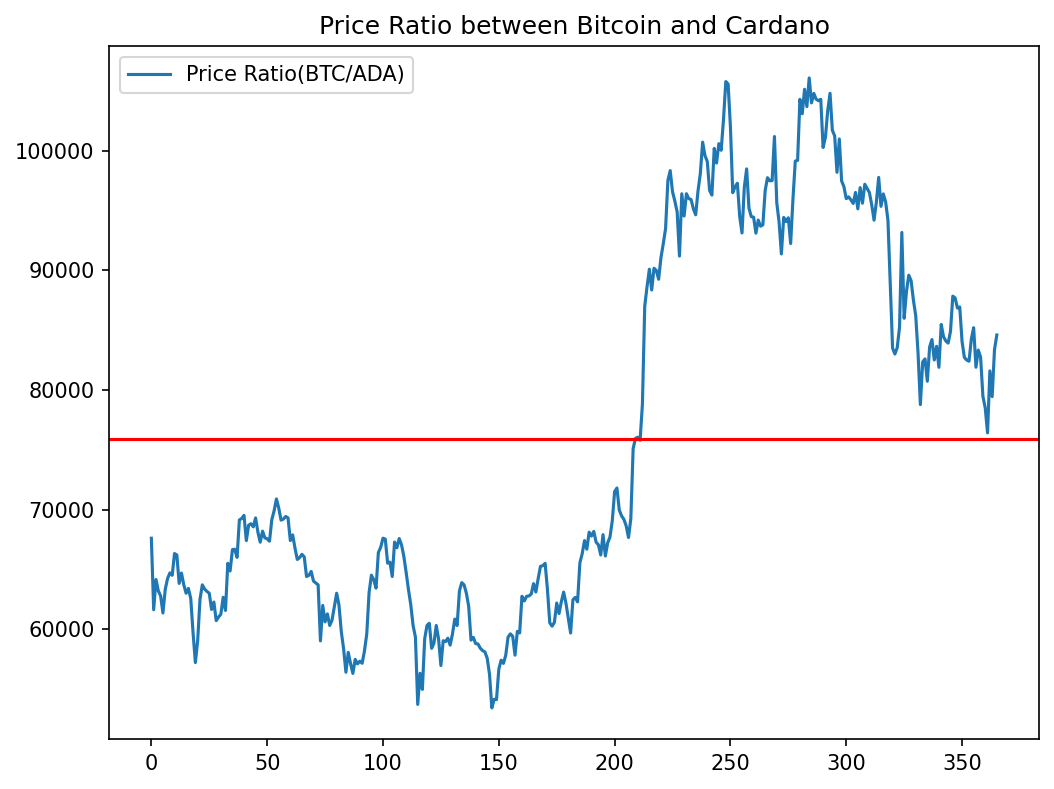

In [194]:
# Also we can take a look at the price ratios between the two time series.
plt.figure(figsize=(8, 6), dpi=150)
ratio = BTC - ADA
plt.plot(ratio, label='Price Ratio(BTC/ADA)')
plt.axhline(ratio.mean(), color='red')
plt.legend()
plt.title('Price Ratio between Bitcoin and Cardano')

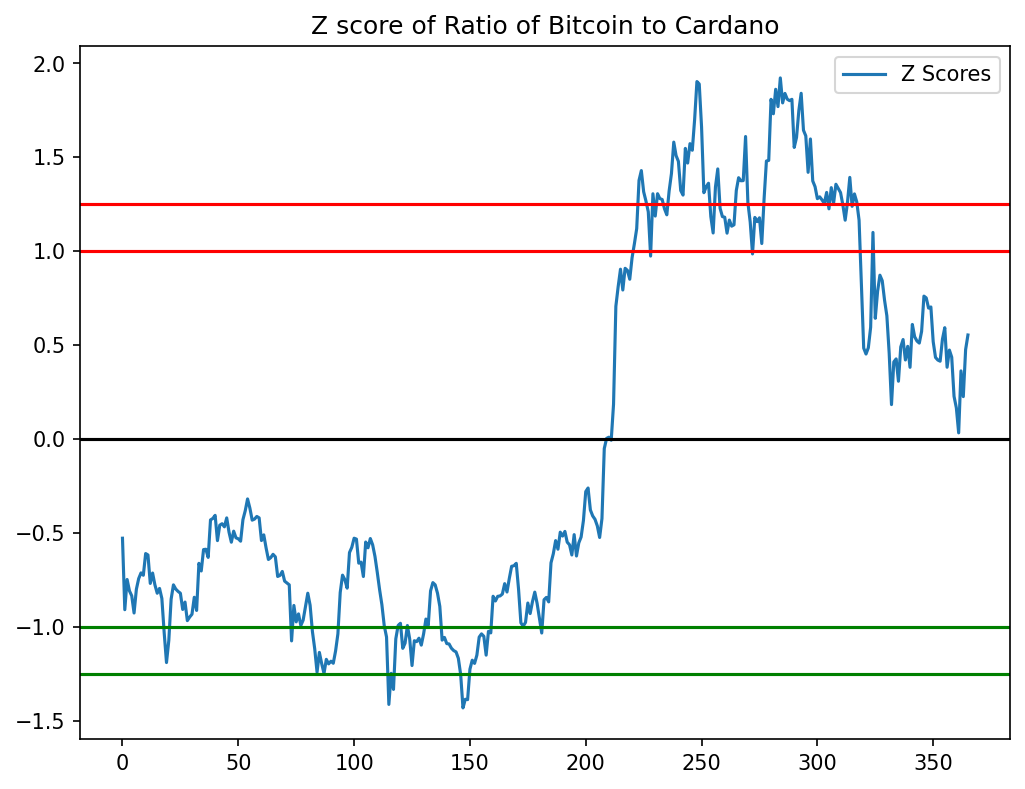

In [195]:
# NOTE, here you can either use the spread OR the Price ratio approach. Anyways, let's standardize the ratio so we can have a 
# upper and lower bound to help evaluate our trends.. Let's stick with the ratio data.
plt.figure(figsize=(8, 6), dpi=150)
# Calculate the Zscores of each row.
df_zscore = (ratio - ratio.mean())/ratio.std()
plt.plot(df_zscore, label = "Z Scores")
plt.axhline(df_zscore.mean(), color = 'black')
plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
plt.axhline(1.25, color='red') # 95% of our data will lie between these bounds.
plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
plt.axhline(-1.25, color='green') # 95% of our data will lie between these bounds.
plt.legend(loc = 'best')
plt.title('Z score of Ratio of Bitcoin to Cardano')
plt.show()
# For the most part, the range that exists outside of these 'bands' must come converge back to the mean. Thus, you can 
# determine when you can go long or short the pair (BRK_B to MSFT).

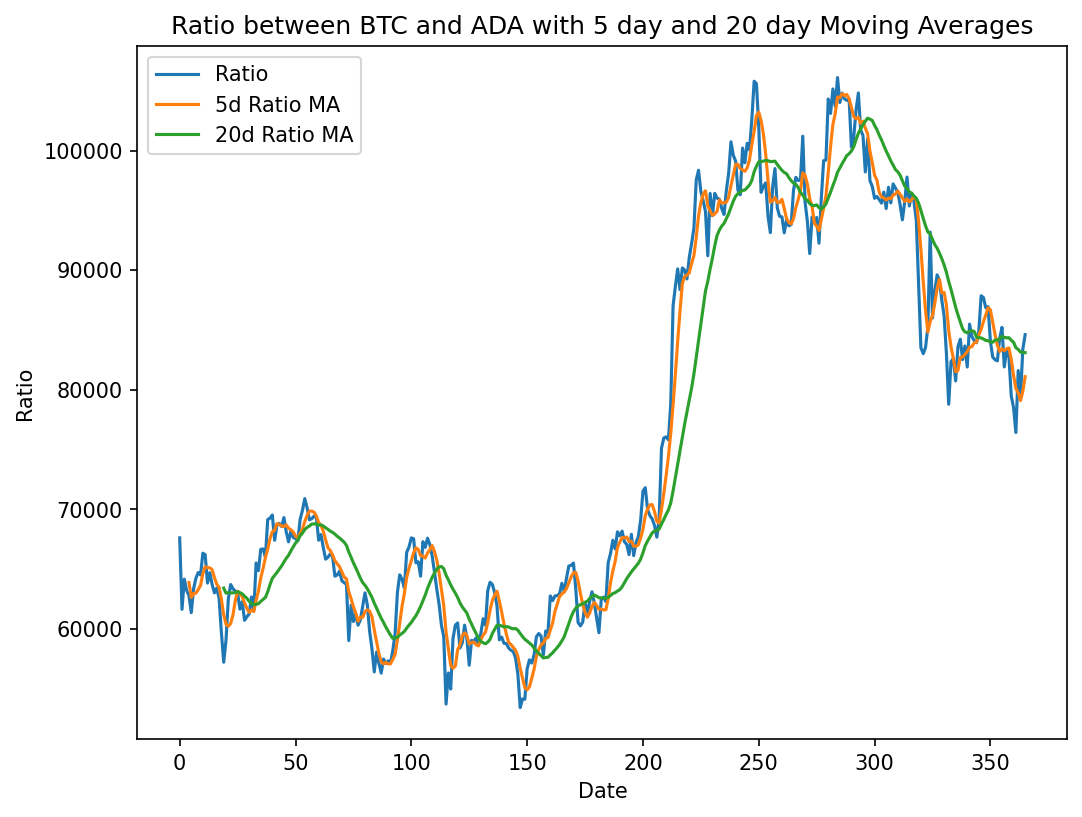

In [196]:
plt.figure(figsize=(8, 6), dpi=150)
ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
ratios_mavg20 = ratio.rolling(window=20, center=False).mean()
std_20 = ratio.rolling(window=20, center=False).std()
zscore_20_5 = (ratios_mavg5 - ratios_mavg20)/std_20
plt.plot(ratio.index, ratio.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg20.index, ratios_mavg20.values)
plt.legend(['Ratio', '5d Ratio MA', '20d Ratio MA'])
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Ratio between BTC and ADA with 5 day and 20 day Moving Averages')
plt.show()

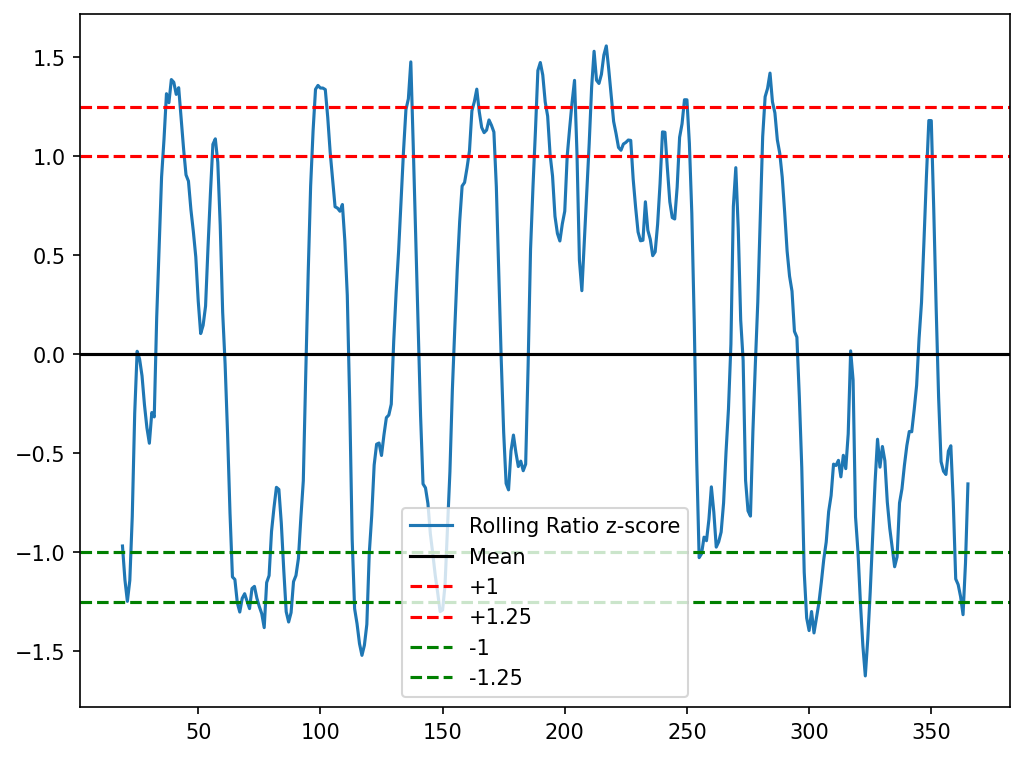

In [197]:
plt.figure(figsize=(8, 6), dpi=150)
zscore_20_5.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(1.25, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(-1.25, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.25','-1','-1.25'])
plt.show()

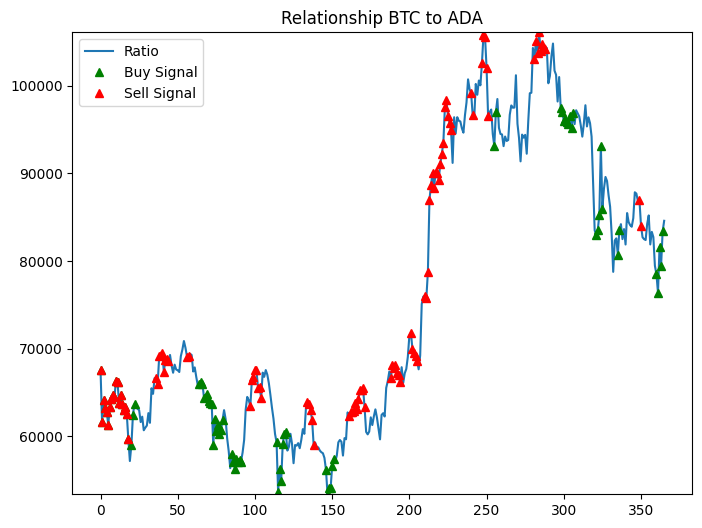

In [198]:
plt.figure(figsize=(8, 6), dpi=100)
ratio.plot()
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_20_5>-1] = 0
sell[zscore_20_5<1] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship BTC to ADA')
plt.show()